In [ ]:
!pip install seqeval evaluate --quiet

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import AutoTokenizer, AutoModelForTokenClassification
from transformers import TrainingArguments, Trainer, TrainerCallback
from datasets import Dataset
import evaluate
import torch
from seqeval.metrics import classification_report as seqeval_classification_report
from seqeval.scheme import IOB2

In [ ]:
# Load and preprocess data
file_path = "/kaggle/input/nerskill/NERSkill.Id.txt"
df = pd.read_csv(file_path, delimiter="\t", names=["Sentence #", "Word", "Tag"], skiprows=1)
df["Sentence #"] = df["Sentence #"].ffill()

# Convert to sentences with (word, tag) pairs
sentences = df.groupby("Sentence #", group_keys=False).apply(
    lambda s: list(zip(s["Word"], s["Tag"]))).tolist()

# Split data
train_sentences, temp_sentences = train_test_split(sentences, test_size=0.3, random_state=42)
val_sentences, test_sentences = train_test_split(temp_sentences, test_size=1/3, random_state=42)

In [ ]:
# Prepare tag mappings (ensure all tags are included)
all_tags = sorted(set(tag for sentence in sentences for _, tag in sentence))
tag2id = {tag: i for i, tag in enumerate(all_tags)}
id2tag = {i: tag for i, tag in enumerate(all_tags)}

# Initialize IndoBERT tokenizer
model_checkpoint = "indobenchmark/indobert-base-p2"
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

In [ ]:
# Tokenize and align labels
def tokenize_and_align_labels(examples):
    tokenized_inputs = tokenizer(
        examples["tokens"],
        truncation=True,
        is_split_into_words=True,
        padding="max_length",
        max_length=128
    )

    labels = []
    for i, label in enumerate(examples["ner_tags"]):
        word_ids = tokenized_inputs.word_ids(batch_index=i)
        previous_word_idx = None
        label_ids = []
        for word_idx in word_ids:
            if word_idx is None:
                label_ids.append(-100)
            elif word_idx != previous_word_idx:
                label_ids.append(label[word_idx])
            else:
                label_ids.append(-100)
            previous_word_idx = word_idx
        labels.append(label_ids)

    tokenized_inputs["labels"] = labels
    return tokenized_inputs

In [ ]:
# Convert to Hugging Face Dataset format
def prepare_dataset(sentences):
    tokens = [[word for word, _ in sentence] for sentence in sentences]
    ner_tags = [[tag2id[tag] for _, tag in sentence] for sentence in sentences]

    return Dataset.from_dict({
        "tokens": tokens,
        "ner_tags": ner_tags
    })

train_dataset = prepare_dataset(train_sentences).map(tokenize_and_align_labels, batched=True)
val_dataset = prepare_dataset(val_sentences).map(tokenize_and_align_labels, batched=True)
test_dataset = prepare_dataset(test_sentences).map(tokenize_and_align_labels, batched=True)

In [ ]:
model = AutoModelForTokenClassification.from_pretrained(
    model_checkpoint,
    num_labels=len(tag2id),
    id2label=id2tag,
    label2id=tag2id
)

# Freeze all layers first
for param in model.base_model.parameters():
    param.requires_grad = False

# Unfreeze top 3 layers gradually
for layer in model.base_model.encoder.layer[-3:]:  # Last 3 transformer layers
    for param in layer.parameters():
        param.requires_grad = True

# Metrics (using seqeval for entity-level evaluation)
seqeval = evaluate.load("seqeval")

In [ ]:
def compute_metrics(p):
    predictions, labels = p
    predictions = np.argmax(predictions, axis=2)

    # Remove ignored index (-100) and convert indices to tag strings
    true_predictions = [
        [id2tag[p] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]
    true_labels = [
        [id2tag[l] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]

    # Calculate entity-level metrics via seqeval
    results = seqeval.compute(predictions=true_predictions, references=true_labels)

    # Flatten for token-level classification report
    flat_true = [tag for sent in true_labels for tag in sent]
    flat_pred = [tag for sent in true_predictions for tag in sent]
    token_report = classification_report(flat_true, flat_pred, output_dict=True)

    return {
        "precision": results["overall_precision"],
        "recall": results["overall_recall"],
        "f1": results["overall_f1"],
        "accuracy": results["overall_accuracy"],
        "token_precision": token_report["weighted avg"]["precision"],
        "token_recall": token_report["weighted avg"]["recall"],
        "token_f1": token_report["weighted avg"]["f1-score"],
    }

In [ ]:
# Verify freezing worked
print("Trainable layers:")
for name, param in model.named_parameters():
    if param.requires_grad:
        print(name)

# Training arguments
training_args = TrainingArguments(
    output_dir="indobert-ner",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    num_train_epochs=5,
    weight_decay=0.01,
    evaluation_strategy="epoch",  # Consider switching to eval_strategy in future versions
    save_strategy="epoch",
    warmup_ratio=0.1,
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    report_to="none",
    logging_steps=100,
)

from torch.optim import AdamW

# Create parameter groups with discriminative learning rates
params = [
    {"params": [p for n, p in model.named_parameters() if "classifier" in n], "lr": 5e-5},
    {"params": [p for n, p in model.named_parameters() if "encoder.layer.11" in n], "lr": 3e-5},
    {"params": [p for n, p in model.named_parameters() if "encoder.layer.10" in n], "lr": 3e-5},
    {"params": [p for n, p in model.named_parameters() if "encoder.layer.9" in n], "lr": 3e-5},
]
optimizer = AdamW(params)

# Create Trainer with custom optimizer (pass both model and optimizer)
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    optimizers=(optimizer, None),  # Pass our custom optimizer
)

# Train the model
trainer.train()


Trainable layers:
bert.encoder.layer.9.attention.self.query.weight
bert.encoder.layer.9.attention.self.query.bias
bert.encoder.layer.9.attention.self.key.weight
bert.encoder.layer.9.attention.self.key.bias
bert.encoder.layer.9.attention.self.value.weight
bert.encoder.layer.9.attention.self.value.bias
bert.encoder.layer.9.attention.output.dense.weight
bert.encoder.layer.9.attention.output.dense.bias
bert.encoder.layer.9.attention.output.LayerNorm.weight
bert.encoder.layer.9.attention.output.LayerNorm.bias
bert.encoder.layer.9.intermediate.dense.weight
bert.encoder.layer.9.intermediate.dense.bias
bert.encoder.layer.9.output.dense.weight
bert.encoder.layer.9.output.dense.bias
bert.encoder.layer.9.output.LayerNorm.weight
bert.encoder.layer.9.output.LayerNorm.bias
bert.encoder.layer.10.attention.self.query.weight
bert.encoder.layer.10.attention.self.query.bias
bert.encoder.layer.10.attention.self.key.weight
bert.encoder.layer.10.attention.self.key.bias
bert.encoder.layer.10.attention.self.v

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-11-54e722616e5f>:36: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy,Token Precision,Token Recall,Token F1
1,No log,0.215013,0.614835,0.632602,0.623592,0.920680,0.917134,0.920680,0.917751
2,0.588100,0.188065,0.661814,0.668856,0.665317,0.928788,0.925184,0.928788,0.926567
3,0.202100,0.180470,0.668120,0.704716,0.685930,0.931745,0.930045,0.931745,0.930752
4,0.180400,0.180627,0.652744,0.738999,0.693199,0.932048,0.934040,0.932048,0.932923
5,0.173600,0.176097,0.671695,0.719427,0.694742,0.933635,0.932467,0.933635,0.932932


/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked t

TrainOutput(global_step=470, training_loss=0.2681706793764804, metrics={'train_runtime': 167.0755, 'train_samples_per_second': 89.989, 'train_steps_per_second': 2.813, 'total_flos': 982193582135040.0, 'train_loss': 0.2681706793764804, 'epoch': 5.0})

In [ ]:
# Evaluate on test set
test_results = trainer.predict(test_dataset)
metrics = test_results.metrics
print("\nTest Set Results:")
# Note: The returned keys are automatically prefixed with "test_" when using predict()
print(f"Token-level Precision: {metrics['test_token_precision']:.4f}")
print(f"Token-level Recall: {metrics['test_token_recall']:.4f}")
print(f"Token-level F1: {metrics['test_token_f1']:.4f}")
print(f"\nEntity-level Precision: {metrics['test_precision']:.4f}")
print(f"Entity-level Recall: {metrics['test_recall']:.4f}")
print(f"Entity-level F1: {metrics['test_f1']:.4f}")

/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(



Test Set Results:
Token-level Precision: 0.9352
Token-level Recall: 0.9355
Token-level F1: 0.9352

Entity-level Precision: 0.6727
Entity-level Recall: 0.7221
Entity-level F1: 0.6965



Detailed Token-Level Classification Report (All Tags):
              precision    recall  f1-score   support

    B-HSkill       0.71      0.65      0.68      1482
    B-SSkill       0.79      0.85      0.82       858
      B-Tech       0.87      0.88      0.87      1355
    I-HSkill       0.63      0.66      0.64       978
    I-SSkill       0.78      0.69      0.73       282
      I-Tech       0.69      0.71      0.70       355
           O       0.97      0.97      0.97     29422

    accuracy                           0.94     34732
   macro avg       0.78      0.77      0.77     34732
weighted avg       0.94      0.94      0.94     34732



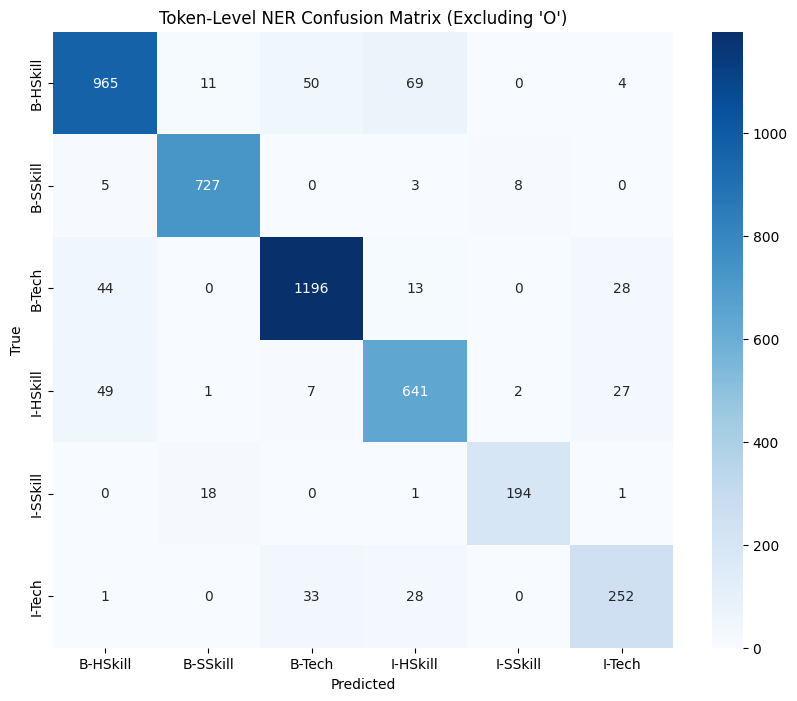

In [ ]:
predictions = np.argmax(test_results.predictions, axis=2)
true_labels_matrix = test_results.label_ids

# Filter out ignored labels (-100) and convert indices to tags
true_predictions = [
    [id2tag[p] for (p, l) in zip(prediction, label) if l != -100]
    for prediction, label in zip(predictions, true_labels_matrix)
]
true_labels = [
    [id2tag[l] for (p, l) in zip(prediction, label) if l != -100]
    for prediction, label in zip(predictions, true_labels_matrix)
]

# Flatten token-level predictions and labels
flat_true = [tag for sent in true_labels for tag in sent]
flat_pred = [tag for sent in true_predictions for tag in sent]

# Exclude tokens whose gold label is 'O'
filtered_indices = [i for i, tag in enumerate(flat_true) if tag != "O"]
flat_true_noO = [flat_true[i] for i in filtered_indices]
flat_pred_noO = [flat_pred[i] for i in filtered_indices]
# Set labels to all entity tags (excluding "O")
entity_labels = [tag for tag in sorted(tag2id.keys()) if tag != "O"]

# Token-level classification report (including 'O' tag)
print("\nDetailed Token-Level Classification Report (All Tags):")
print(classification_report(flat_true, flat_pred, target_names=sorted(tag2id.keys())))

cm_token = confusion_matrix(flat_true_noO, flat_pred_noO, labels=entity_labels)
plt.figure(figsize=(10, 8))
sns.heatmap(cm_token, annot=True, fmt="d", cmap="Blues", xticklabels=entity_labels, yticklabels=entity_labels)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Token-Level NER Confusion Matrix (Excluding 'O')")
plt.show()


Entity-Level Classification Report (seqeval):
              precision    recall  f1-score   support

      HSkill       0.62      0.56      0.59      1482
      SSkill       0.75      0.81      0.78       858
        Tech       0.80      0.82      0.81      1355

   micro avg       0.72      0.71      0.72      3695
   macro avg       0.72      0.73      0.73      3695
weighted avg       0.72      0.71      0.71      3695



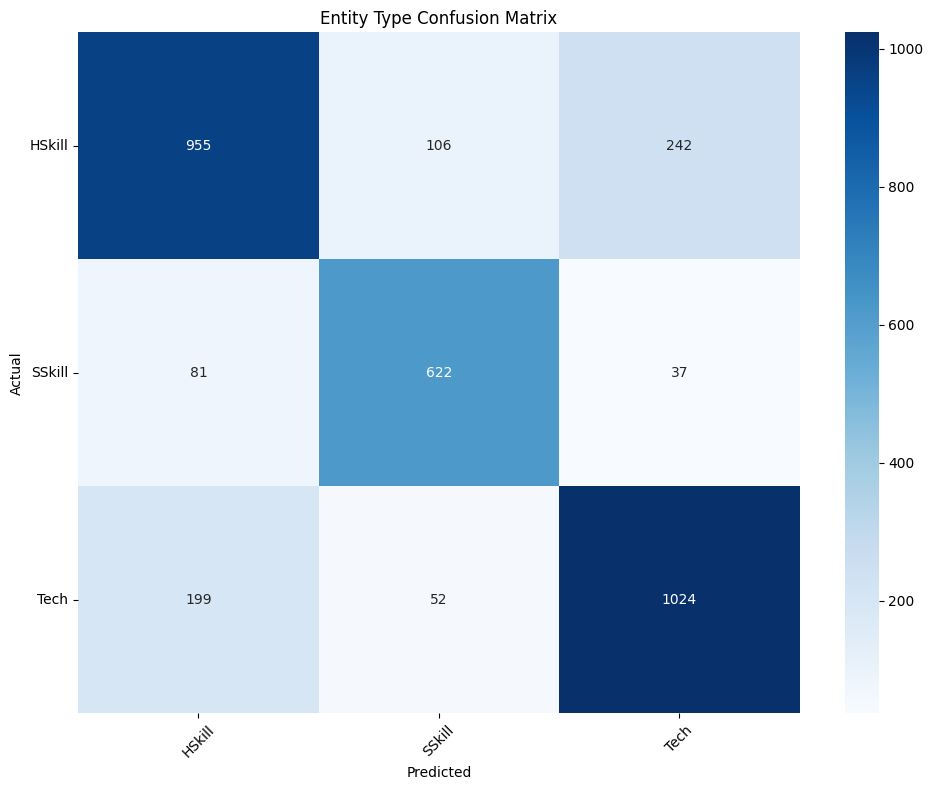

In [ ]:
# Extract true predictions and labels (removing padding labels -100)
true_predictions = [
    [id2tag[p] for (p, l) in zip(pred, label) if l != -100]
    for pred, label in zip(np.argmax(test_results.predictions, axis=2), test_results.label_ids)
]
true_labels = [
    [id2tag[l] for l in label if l != -100]
    for label in test_results.label_ids
]

# Generate and print the seqeval entity-level classification report
print("\nEntity-Level Classification Report (seqeval):")
print(seqeval_classification_report(true_labels, true_predictions, mode='strict', scheme=IOB2))

# Define a helper function to extract entity types from a sequence.
def get_entity_types(tag_sequence):
    """
    Extracts entity types from a tag sequence.
    When a tag starts with 'B-', it registers a new entity.
    For simplicity, this function only collects the types (i.e., without their span positions).
    """
    entities = []
    for tag in tag_sequence:
        if tag.startswith('B-'):
            # Append the entity type (without the prefix "B-")
            entities.append(tag[2:])
    return entities

# Build lists for the confusion matrix.
y_true = []
y_pred = []

for gold_seq, pred_seq in zip(true_labels, true_predictions):
    # Extract entity types from the current sentence.
    gold_entities = get_entity_types(gold_seq)
    pred_entities = get_entity_types(pred_seq)

    # Determine the maximum number of entities between the two lists.
    max_len = max(len(gold_entities), len(pred_entities))

    # Pad the shorter list with the placeholder "None".
    if len(gold_entities) < max_len:
        gold_entities = gold_entities + ["None"] * (max_len - len(gold_entities))
    if len(pred_entities) < max_len:
        pred_entities = pred_entities + ["None"] * (max_len - len(pred_entities))

    # Extend the overall lists.
    y_true.extend(gold_entities)
    y_pred.extend(pred_entities)

# Optionally: Remove the "None" placeholder from the labels list if you prefer to focus only on recognized entity types.
all_entity_types = sorted(set(y_true + y_pred))
if "None" in all_entity_types:
    all_entity_types.remove("None")

# Compute the confusion matrix using the list of entity types.
cm = confusion_matrix(y_true, y_pred, labels=all_entity_types)

# Plot the confusion matrix.
plt.figure(figsize=(10, 8))
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=all_entity_types,
    yticklabels=all_entity_types
)
plt.title('Entity Type Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()
